In [9]:
import matplotlib.pyplot as plt #basic plotting
import plotly.express as px #interactive plots
import seaborn as sns #visualisation of multidimensional data
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load data
Real data of groundwater levels for two measurement stations acquired weekly.

In [10]:
# read csv, convert strings to dates, set index to date, and assure weekly frequency
gwl = pd.read_csv("https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/gwl.csv", parse_dates=True, index_col=0).asfreq('W-SUN')
era = pd.read_csv("https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/era.csv", parse_dates=True, index_col=0).asfreq('W-SUN')

# Exploratory Data Analysis

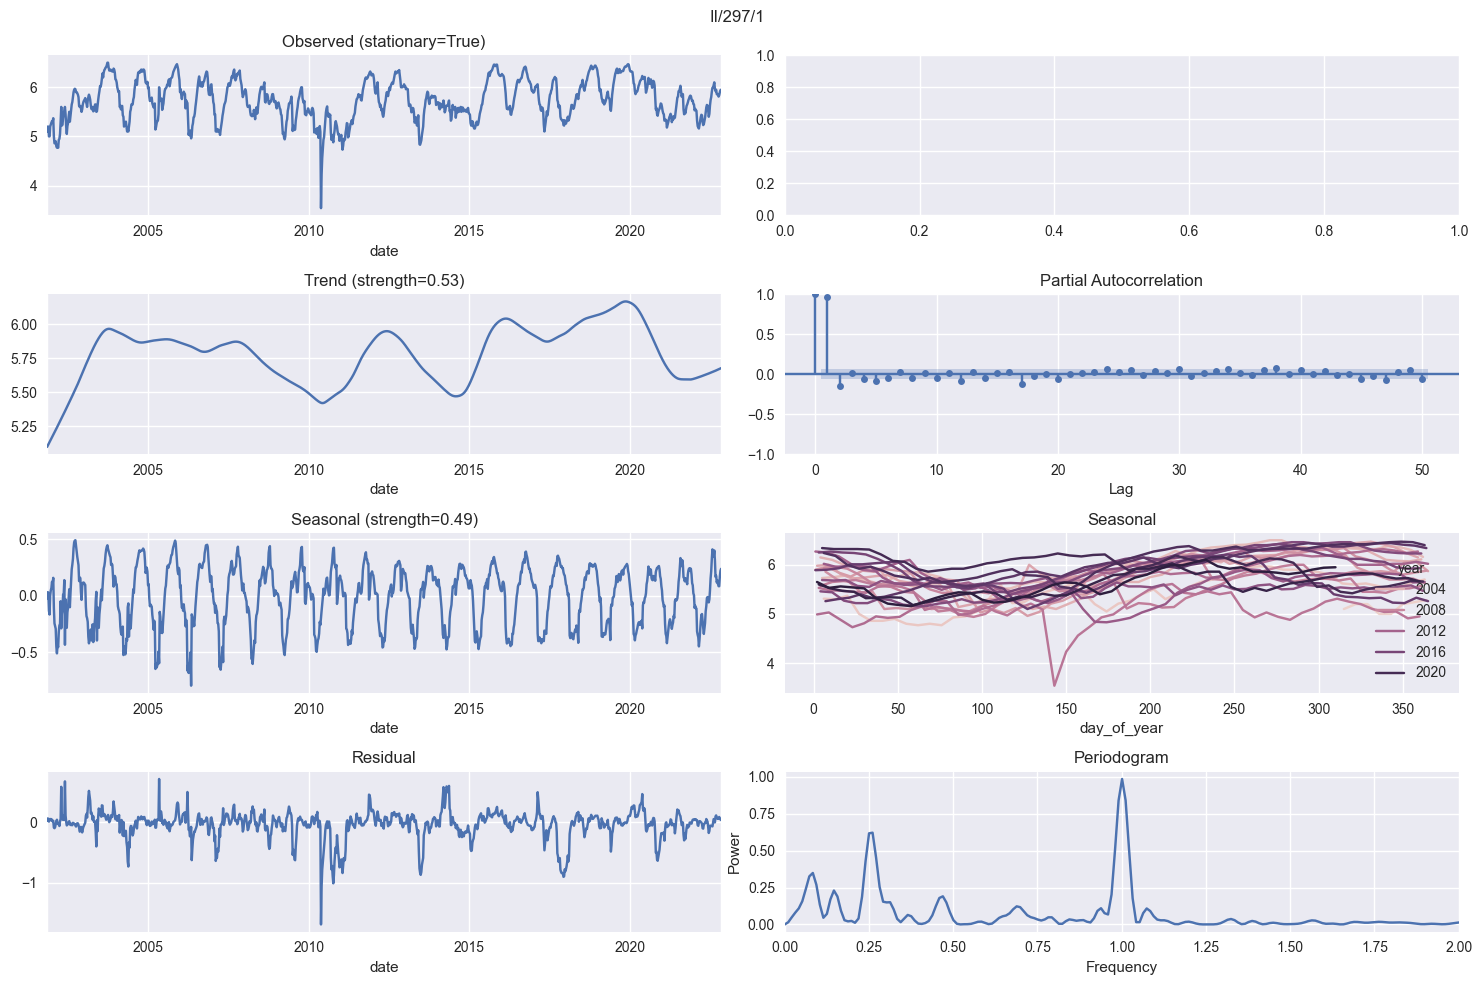

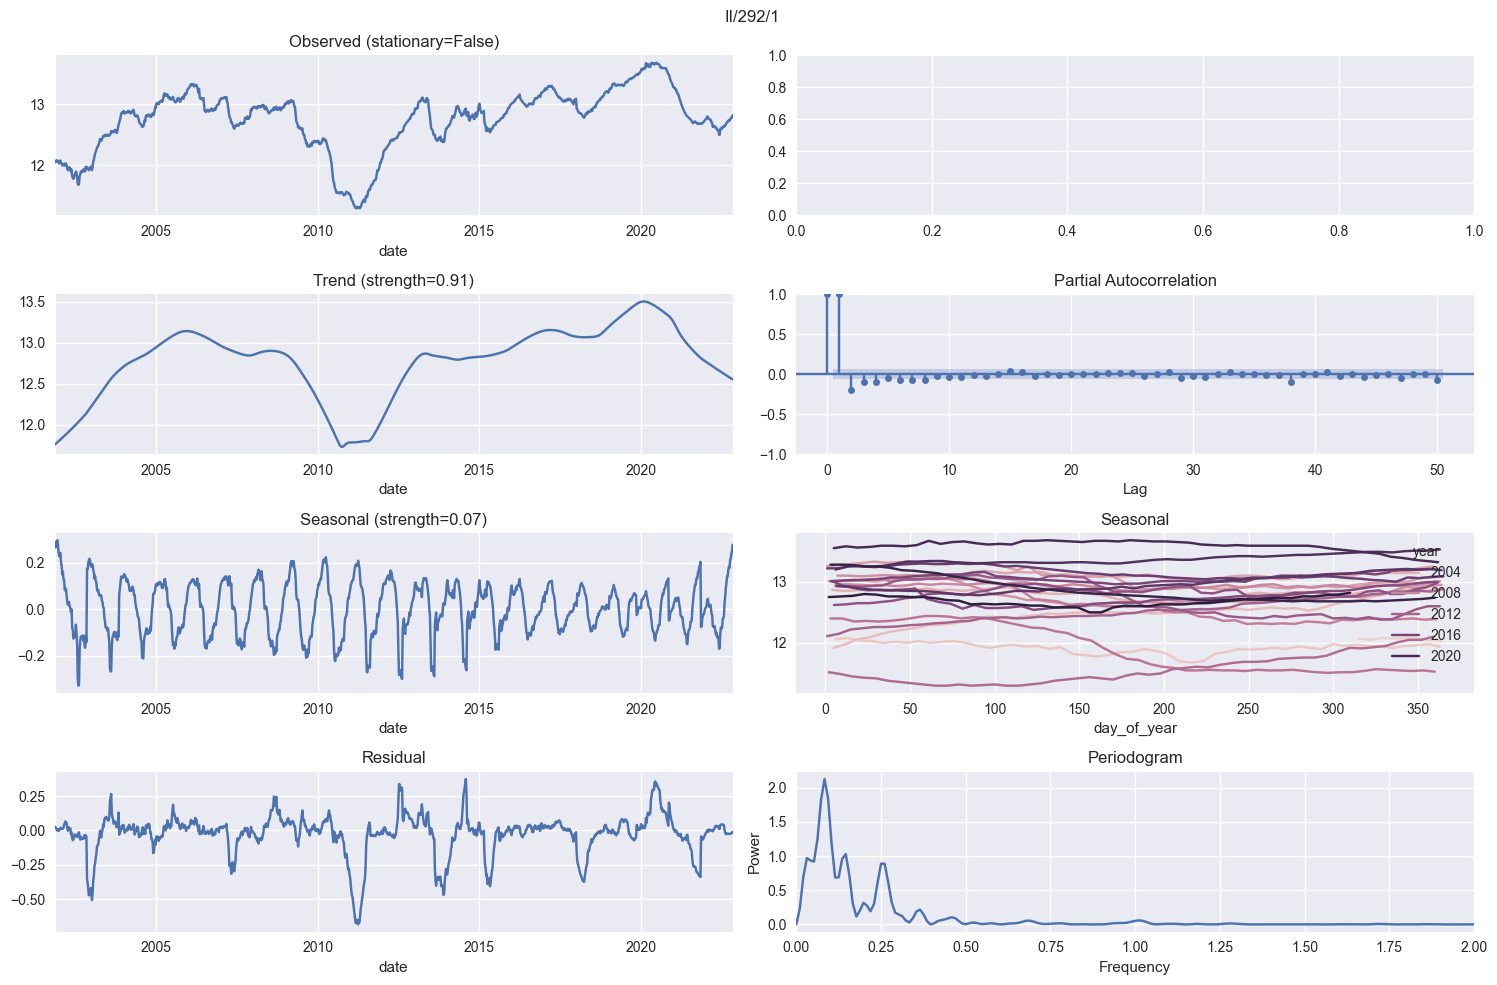

In [11]:
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

for c in gwl.columns:
    
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
    fig.suptitle(c)
    # Stationarity test
    is_stationary = adfuller(gwl[c].dropna())[1] < 0.05
    # STL decomposition
    res = STL(gwl[c].dropna(), period=52, robust=True).fit()
    seasonal_strength = max(0,1 - res.resid.var() / (res.seasonal+res.resid).var()) #https://otexts.com/fpp3/stlfeatures.html
    trend_strength = max(0,1 - res.resid.var() / (res.trend+res.resid).var()) #https://otexts.com/fpp3/stlfeatures.html
    res.observed.plot(ax=ax[0,0])
    ax[0,0].set_title(f"Observed (stationary={is_stationary})")
    res.trend.plot(ax=ax[1,0])
    ax[1,0].set_title(f"Trend (strength={trend_strength:.2f})")
    res.seasonal.plot(ax=ax[2,0])
    ax[2,0].set_title(f"Seasonal (strength={seasonal_strength:.2f})")
    res.resid.plot(ax=ax[3,0])
    ax[3,0].set_title("Residual")
    # Partial autocorrelation
    plot_pacf(gwl[c].dropna().values, lags=50, ax=ax[1,1])
    ax[1,1].set_xlabel("Lag")
    # Seasonal plot
    tmp_df = gwl[[c]].copy()
    tmp_df["day_of_year"] = tmp_df.index.dayofyear
    tmp_df["year"] = tmp_df.index.year
    sns.lineplot(x = tmp_df["day_of_year"], y = tmp_df[c], hue=tmp_df["year"], color="black", ax=ax[2,1])
    ax[2,1].set_title("Seasonal")
    ax[2,1].set_ylabel(None)
    # Periodogram
    f, p = periodogram(gwl[c].dropna(), fs=1/(7/365), nfft=5000)
    ax[3,1].plot(f, p)
    ax[3,1].set_title("Periodogram")
    ax[3,1].set_xlim([0, 2])
    ax[3,1].set_xlabel("Frequency")
    ax[3,1].set_ylabel("Power")

    fig.tight_layout()
    plt.show()

# Modelling

**Workflow**
1. Fitting model using lagged era data and known previous time step value of ground water level as input features.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/1_training.png" alt="drawing" width="1000"/>

2. Iteratively building a test prediction using lagged era data and predicted in previous iteration value of ground water level as input fetures.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/2_iterative_test.gif" alt="drawing" width="1000"/>

3. Analogous multiple iterative predictions in train dataset in order to calculate standard deviation of residuals for each step of forecast horizon.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/3_train_horizon.gif" alt="drawing" width="1000"/>

4. 95% confidence interval as 1.96*STD obtained in iterative predictions in train dataset.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/4_confidence_interval.png" alt="drawing" width="1000"/>

100%|██████████| 45/45 [00:08<00:00,  5.52it/s]


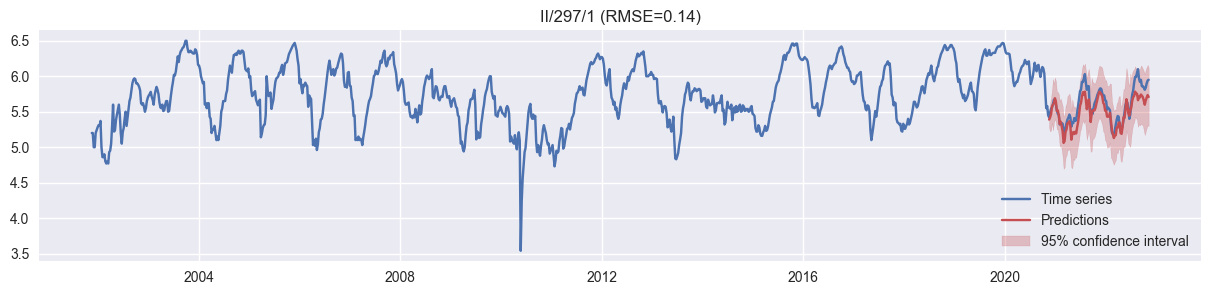

100%|██████████| 45/45 [00:08<00:00,  5.49it/s]


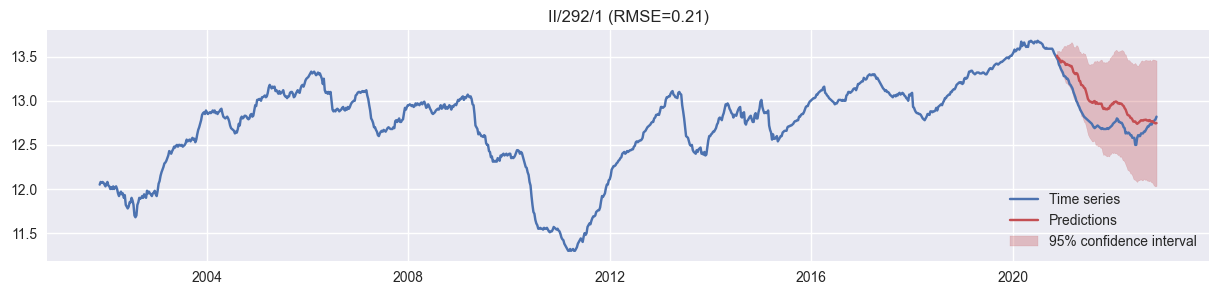

In [17]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
for station in gwl.columns:
    forecast_horizon = 52*2 # 104 weeks = 2 years
    station_gwl = gwl[station].rename("gwl")
    # dataset with lagged features
    era_lags_vals = []
    for date, value in station_gwl.items():
        era_lags_vals.append(era.loc[date - pd.Timedelta(weeks=51):date].sort_index(ascending=False).values.flatten())
    era_lags_vals = np.array(era_lags_vals)
    era_lags_cols = [f"{col}-{lag}" for lag in range(52) for col in era.columns]
    era_lags_df = pd.DataFrame(era_lags_vals, columns=era_lags_cols, index=station_gwl.index)
    prev_y = station_gwl.shift(1).dropna().rename("y-1")
    curr_y = station_gwl.loc[prev_y.index].rename("y-0")
    dataset = pd.concat([era_lags_df.loc[prev_y.index], prev_y, curr_y], axis=1)
    train_dataset = dataset.iloc[:-forecast_horizon]
    test_dataset = dataset.iloc[-forecast_horizon:]
    
    # training
    x_train = train_dataset.drop("y-0", axis=1)
    y_train = train_dataset[["y-0"]]
    x_scaler = StandardScaler().fit(x_train)
    y_scaler = StandardScaler().fit(y_train)
    model = Ridge()
    model.fit(x_scaler.transform(x_train), y_scaler.transform(y_train))
    
    # uncertainty
    n_samples = len(x_train)-forecast_horizon
    true_ys = []
    pred_ys = []
    pred_steps = []
    dates = []
    subsets = []
    for i in tqdm(range(0,n_samples, 20)):
        x_train_subset = x_train.iloc[i:i+forecast_horizon]
        y_train_subset = y_train.iloc[i:i+forecast_horizon]
        prev_y = x_train_subset["y-1"].values[0]
        for j in range(forecast_horizon):
            x_train_row = x_train_subset.iloc[j:j+1].copy()
            x_train_row["y-1"] = prev_y
            y_pred = y_scaler.inverse_transform(model.predict(x_scaler.transform(x_train_row))).item()
            prev_y = y_pred
            true_ys.append(y_train_subset.iloc[j].item())
            pred_ys.append(y_pred)
            pred_steps.append(j)
            subsets.append(i)
            dates.append(y_train_subset.index[j])
    uncertainty_df = pd.DataFrame({"true_y": true_ys, "pred_y": pred_ys, "pred_step": pred_steps, "subset": subsets, "date": dates})
    uncertainty_df["residuals"] = uncertainty_df["true_y"] - uncertainty_df["pred_y"]
    uncertainties = uncertainty_df.groupby("pred_step")["residuals"].std()*1.96
    
    # testing
    x_test = test_dataset.drop("y-0", axis=1)
    y_test = test_dataset[["y-0"]]
    prev_y = test_dataset["y-1"].values[0]
    predictions = []
    for i in range(forecast_horizon):
        x_test_row = x_test.iloc[i:i+1].copy()
        x_test_row["y-1"] = prev_y
        y_pred = y_scaler.inverse_transform(model.predict(x_scaler.transform(x_test_row))).item()
        prev_y = y_pred
        predictions.append(y_pred)
    
    rmse = np.sqrt(np.mean((y_test.values.squeeze() - predictions)**2))
    
    plt.figure(figsize=(15,3))
    plt.plot(dataset.index, dataset["y-0"], label="Time series", color=colors[0])
    plt.plot(test_dataset.index, predictions, label="Predictions", color=colors[2])
    plt.fill_between(test_dataset.index, predictions-uncertainties, predictions+uncertainties, alpha=0.3, label="95% confidence interval", color=colors[2])
    plt.title(f"{station} (RMSE={rmse:.2f})")
    plt.legend(loc="lower right")
    plt.show()